In [53]:
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
import datetime
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, make_scorer
from scipy.stats import randint as sp_randint

In [54]:
%matplotlib inline

In [3]:
#final_train_users_path = '../../Data/final_train_users.csv'
#final_train_users = pd.read_csv(final_train_users_path)
#final_train_users.head()

train_users_path = '../../Data/train_users_2.csv'
train_users = pd.read_csv(train_users_path)
sessions = pd.read_csv('../../Data/sessions.csv')

#Drop train users that are not in sessions
final_train_users = train_users[train_users['id'].drop_duplicates().isin(sessions['user_id'].drop_duplicates())]
final_train_users = final_train_users.reset_index()
final_train_users.head()

,index,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,137021,d1mm9tcy42,2014-01-01,20140101000936,2014-01-04,MALE,62.0,basic,0,en,sem-non-brand,google,omg,Web,Windows Desktop,Chrome,other
1,137022,yo8nz8bqcq,2014-01-01,20140101001558,NaN,-unknown-,NaN,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,NDF
2,137023,4grx6yxeby,2014-01-01,20140101001639,NaN,-unknown-,NaN,basic,0,en,sem-brand,google,omg,Web,Windows Desktop,Firefox,NDF
3,137024,ncf87guaf0,2014-01-01,20140101002146,NaN,-unknown-,NaN,basic,0,en,direct,direct,linked,Web,Windows Desktop,Chrome,NDF
4,137025,4rvqpxoh3h,2014-01-01,20140101002619,2014-01-02,-unknown-,NaN,basic,25,en,direct,direct,untracked,iOS,iPhone,-unknown-,GB


In [4]:
sessions_path = '../../Data/sessions.csv'
sessions = pd.read_csv(sessions_path)
sessions.head()

,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,319.0
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753.0
2,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,301.0
3,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,22141.0
4,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,435.0


In [19]:
def action_bool(action):
    user_action = sessions[sessions['action'] == action]
    performed = final_train_users['id'].isin(user_action['user_id'])
    colname = 'b_' + action
    final_train_users[colname] = performed

0                                    lookup
1                            search_results
7                               personalize
8                                     index
14                         similar_listings
15                    ajax_refresh_subtotal
18                                     show
42                           header_userpic
44                             ask_question
78              other_hosting_reviews_first
103                    hosting_social_proof
117                           decision_tree
118                     recent_reservations
119                      faq_experiment_ids
120                                   multi
121                                  active
127                               dashboard
128                                  create
129                           confirm_email
131                        show_personalize
136                                  verify
139                                 pending
140                             

In [66]:
#actions = ['header_userpic','similar_listings','active']
actions = sessions['action'].dropna().drop_duplicates()
for action in actions:
    action_bool(action)
    
final_train_users.head()

,index,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,...,b_south-america,b_braintree_client_token,b_view,b_stpcv,b_set_minimum_payout_amount,b_support_phone_numbers,b_refund_guest_cancellation,b_accept_decline,b_deactivated,b_rest-of-world
0,137021,d1mm9tcy42,2014-01-01,20140101000936,2014-01-04,MALE,62.0,basic,0,en,...,False,False,False,False,False,False,False,False,False,False
1,137022,yo8nz8bqcq,2014-01-01,20140101001558,NaN,-unknown-,NaN,basic,0,en,...,False,False,False,False,False,False,False,False,False,False
2,137023,4grx6yxeby,2014-01-01,20140101001639,NaN,-unknown-,NaN,basic,0,en,...,False,False,False,False,False,False,False,False,False,False
3,137024,ncf87guaf0,2014-01-01,20140101002146,NaN,-unknown-,NaN,basic,0,en,...,False,False,False,False,False,False,False,False,False,False
4,137025,4rvqpxoh3h,2014-01-01,20140101002619,2014-01-02,-unknown-,NaN,basic,25,en,...,False,False,False,False,False,False,False,False,False,False


In [67]:
feats = map(lambda x: 'b_' + x,actions)
X = final_train_users[feats + ['country_destination']]
Xsh = shuffle(X,random_state = 42).reset_index()
Xsh = Xsh.as_matrix()[:,1:]
ntrain = 50000

Xtrain = Xsh[:ntrain,:-1]
ytrain = np.ravel(Xsh[:ntrain,-1:] != 'NDF')

Xval = Xsh[ntrain:,:-1]
yval = np.ravel(Xsh[ntrain:,-1:] != 'NDF')

print Xtrain.shape, ytrain.shape, Xval.shape, yval.shape

print 'Non NDF in train: {0}'.format(sum(ytrain))
print 'Non NDF in val: {0}'.format(sum(yval))

(50000, 359) (50000,) (23815, 359) (23815,)
Non NDF in train: 19441
Non NDF in val: 9333


In [91]:
labels = np.ravel(Xsh[:,-1:] != 'NDF')

AUC ROC curve: 0.710804996542
Train accuracy 0.88656
Test accuracy 0.692756665967
Number of Actions 359


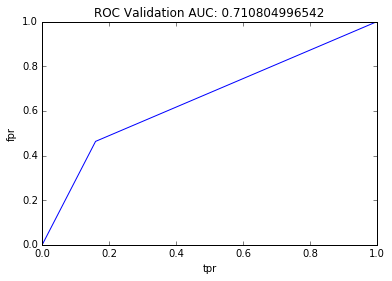

In [118]:
clf = RandomForestClassifier(n_estimators=100)
clf.fit(Xtrain,ytrain)
pred_train = clf.predict(Xtrain)
pred_val = clf.predict(Xval)

fpr,tpr,_ = metrics.roc_curve(yval,pred_val)
auc_roc = metrics.roc_auc_score(yval,clf.predict_proba(Xval)[:,1])

print 'AUC ROC curve: {0}'.format(auc_roc)
print 'Train accuracy {0}'.format(np.mean(pred_train == ytrain))
print 'Test accuracy {0}'.format(np.mean(pred_val == yval))
print 'Number of Actions {0}'.format(len(actions))

plt.plot(fpr,tpr)
plt.title('ROC Validation AUC: {0}'.format(auc_roc))
plt.ylabel('fpr')
plt.xlabel('tpr')
plt.show()

In [92]:
param_dist = {"max_depth": [3, None],
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

# run randomized search
n_iter_search = 8
ftwo_scorer = make_scorer(f1_score)
clf = RandomForestClassifier()
random_search = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=n_iter_search,scoring = ftwo_scorer)

In [93]:
kf = KFold(n_splits=5,shuffle=True, random_state=42)

In [98]:
[:ntrain,:-1]

array([False, False, False, ..., False,  True, False], dtype=bool)

In [119]:
labels = np.ravel(Xsh[:,-1:] != 'NDF')
score = []
fpr = []
tpr = []
roc_auc = []
for train_index, val_index in kf.split(Xsh):
    X_train, X_val = Xsh[train_index,:-1], Xsh[val_index,:-1]
    y_train, y_val = labels[train_index], labels[val_index]
    
    random_search.fit(X_train, y_train)
    rs = random_search.best_params_

    clf = RandomForestClassifier(bootstrap=rs['bootstrap'],criterion=rs['criterion'],max_depth=rs['max_depth'])
    clf.fit(X_train,y_train)
    
    #ROC 
    scores = clf.predict_proba(X_val)
    #prob = np.max((scores),axis=1)
    prob = scores[:,1]

    f, t, thresholds = metrics.roc_curve(y_val, prob)
    fpr.append(f)
    tpr.append(t)
    roc_auc.append(metrics.auc(f,t))

In [109]:
print roc_auc

[0.5068151251134837, 0.49004604997828377, 0.4953868568515935, 0.48785737765686943, 0.49389525705805115]


In [113]:
X_train.shape

(59052, 359)

In [114]:
y_train

array([False, False,  True, ..., False,  True, False], dtype=bool)

# Make a classifier that only classifies between country destination and no country destination based on the difference in days between date account created and July 2014 (Because this was the date that showed the sharpest dropoff according to Arvind's graph

In [6]:
final_sessions = sessions[sessions['user_id'].isin(final_train_users['id'])]
users_sesh = final_sessions[final_sessions['action'] == 'header_userpic']['user_id']

dfact = final_train_users[final_train_users['id'].isin(users_sesh)]
dfnonact = final_train_users[~final_train_users['id'].isin(users_sesh)]

In [7]:
a = np.array(dfact['country_destination'] == 'NDF')
b = np.array(dfnonact['country_destination'] == 'NDF')

X = np.array([1.0]*len(dfact) + [0.0]*len(dfnonact))
labels = np.concatenate((a,b))

X = X[:, np.newaxis]

In [32]:
print X.shape, labels.shape

(73815, 1) (73815,)


train = train_users[['date_account_created','country_destination']].dropna()

#Function to get the number of days between account created date and Baseline date July 2014
def basedate(d1):
    date_format = "%Y-%m-%d"
    d2 = '2014-7-1'
    a = datetime.datetime.strptime(d1, date_format)
    b = datetime.datetime.strptime(d2, date_format)
    delta = b - a
    
    return delta.days

#Shuffle Training Set
trainsh = shuffle(train,random_state = 42).reset_index()

#Split into Train and Validation
Xtrain = np.array(trainsh['date_account_created'][:170000].apply(basedate))
ytrain = trainsh['country_destination'][:170000] != 'NDF'

Xval = np.array(trainsh['date_account_created'][170000:].apply(basedate))
yval = trainsh['country_destination'][170000:] != 'NDF'

Xtrain = Xtrain[:, np.newaxis]
Xval = Xval[:, np.newaxis]

In [34]:
ntrain = 50000
Xtrain = X[:ntrain]
ytrain = labels[:ntrain]
Xval = X[ntrain:]
yval = labels[ntrain:]

In [35]:
kf = KFold(n_splits=5,shuffle=True, random_state=42)


param_dist = {"max_depth": [100, 50, 30, 10, 3, None],
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

# run randomized search
clf = RandomForestClassifier()
n_iter_search = 8
ftwo_scorer = make_scorer(f1_score)
random_search = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=n_iter_search,scoring = ftwo_scorer)


In [40]:
score = []
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = labels[train_index], labels[val_index]
    
    random_search.fit(X_train, y_train)
    rs = random_search.best_params_
    clf = RandomForestClassifier(bootstrap=rs['bootstrap'],criterion=rs['criterion'],max_depth=rs['max_depth'])
    clf.fit(X_train,y_train)
    
    predictions = clf.predict(X_val)
    f = accuracy_score(predictions,y_val)
    score.append(f)

    print X_train.shape, X_val.shape

print score    

(59052, 1) (14763, 1)
(59052, 1) (14763, 1)
(59052, 1) (14763, 1)
(59052, 1) (14763, 1)
(59052, 1) (14763, 1)
[0.61261261261261257, 0.61362866626024526, 0.6102418207681366, 0.60638081690713275, 0.60807423965318708]


<generator object split at 0x7f26fb0770f0>